# Partie A – Clustering

**Dataset**: Mall Customer Segmentation Data

**Objectif**: Segmenter les clients du centre commercial en groupes homogènes.

### Plan
1. Chargement du jeu de données
2. Nettoyage et prétraitement
3. EDA univariée et multivariée

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import warnings
warnings.filterwarnings('ignore', message='.*memory leak on Windows with MKL.*')
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Chargement des données
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:

# Vérification des valeurs manquantes
print(df.isnull().sum())

# Standardisation des variables quantitatives
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
df_scaled.head()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,-1.424569,-1.738999,-0.434801
1,2,Male,-1.281035,-1.738999,1.195704
2,3,Female,-1.352802,-1.700830,-1.715913
3,4,Female,-1.137502,-1.700830,1.040418
4,5,Female,-0.563369,-1.662660,-0.395980


## EDA Univariée
Histogrammes et boxplots des variables quantitatives

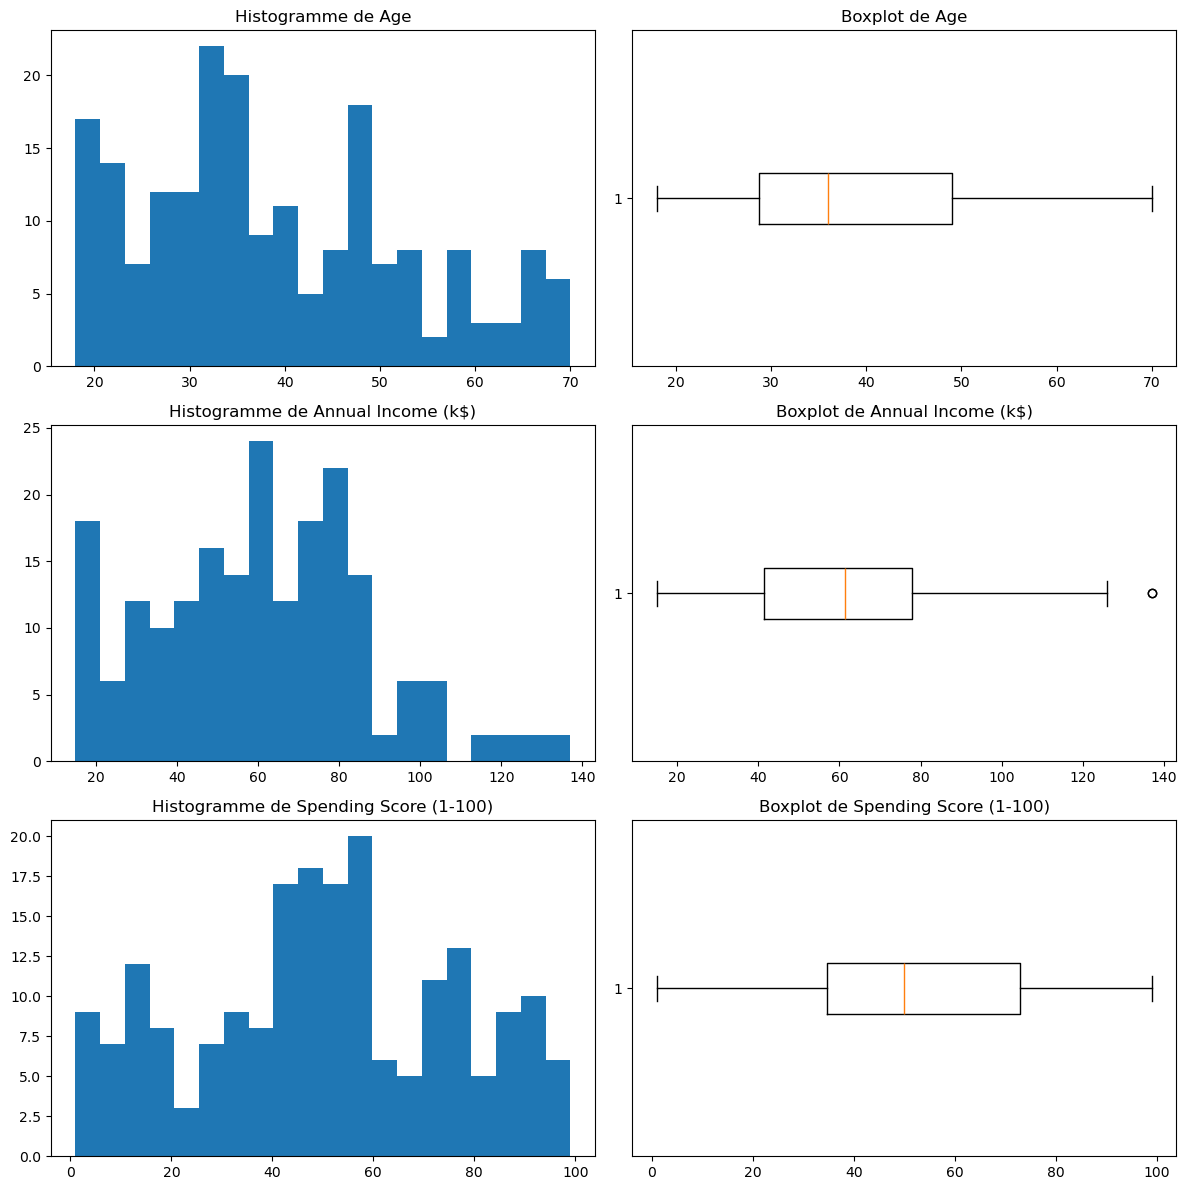

In [6]:

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
variables = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for i, var in enumerate(variables):
    ax_hist = axes[i][0]
    ax_box = axes[i][1]
    ax_hist.hist(df[var], bins=20)
    ax_hist.set_title(f'Histogramme de {var}')
    ax_box.boxplot(df[var], vert=False)
    ax_box.set_title(f'Boxplot de {var}')
plt.tight_layout()
plt.show()

## EDA Multivariée
Matrice de corrélation et scatter-plot matrix

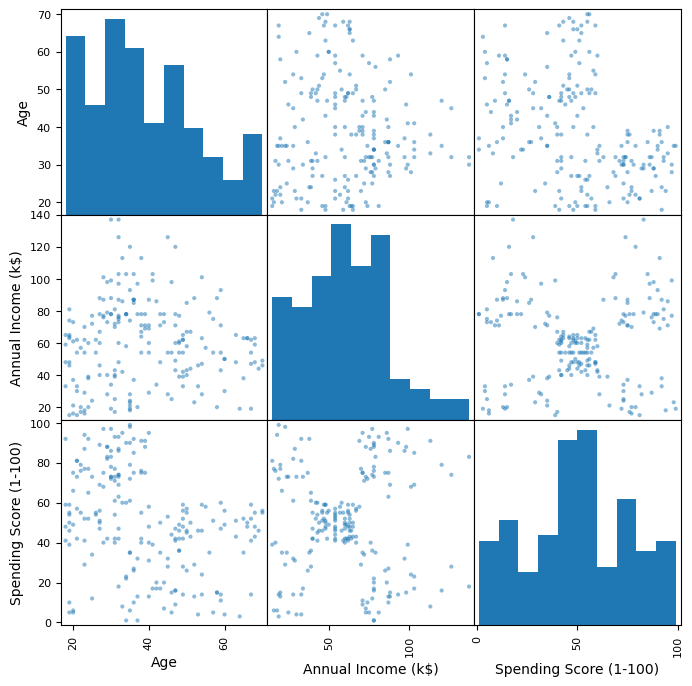

In [9]:

# Matrice de corrélation
corr_matrix = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()
corr_matrix

# Scatter plot matrix
scatter_matrix(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], figsize=(8, 8), diagonal='hist')
plt.show()

## Interprétations
- **Histogrammes & Boxplots** : Identification des distributions et des valeurs aberrantes potentielles.
- **Corrélation** : Permet de détecter les relations linéaires entre les variables.
- **Scatter Matrix** : Visualisation des interactions bivariées pour guider le clustering.

## 4. Feature Engineering / Sélection
- Suppression des features non-informatives (CustomerID).
- Création d'un ratio Revenu/Score.
- Catégorisation de l'âge en classes.

In [13]:

# Suppression des features non-informatives
df_fe = df_scaled.drop(columns=['CustomerID'])

# Création d'un ratio Annual Income / Spending Score
df_fe['Income_Score_Ratio'] = df_fe['Annual Income (k$)'] / (df_fe['Spending Score (1-100)'] + 1e-4)

# Catégorisation de l'âge
bins = [0, 25, 40, 60, 100]
labels = ['Jeune', 'Adulte', 'Mature', 'Senior']
df_fe['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Affichage des nouvelles colonnes
df_fe[['Income_Score_Ratio', 'AgeGroup']].head()

,Income_Score_Ratio,AgeGroup
0,4.000445,Jeune
1,-1.454251,Jeune
2,0.991268,Jeune
3,-1.634599,Jeune
4,4.199911,Adulte


### Visualisation du ratio et des classes d'âge

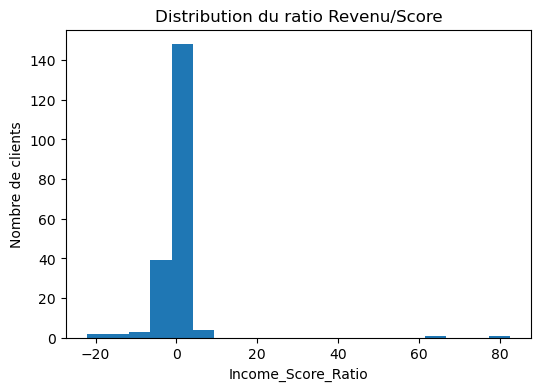

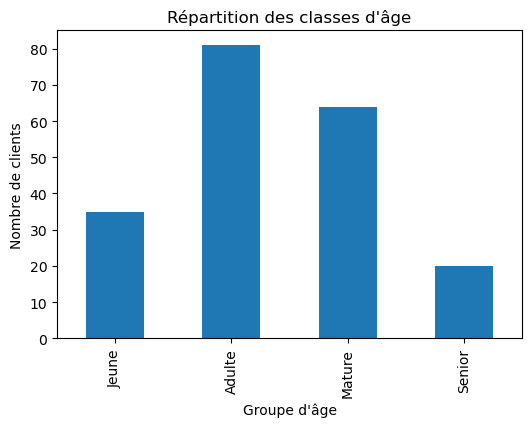

In [16]:

# Histogramme du ratio
plt.figure(figsize=(6,4))
plt.hist(df_fe['Income_Score_Ratio'], bins=20)
plt.title('Distribution du ratio Revenu/Score')
plt.xlabel('Income_Score_Ratio')
plt.ylabel('Nombre de clients')
plt.show()

# Comptage des classes d'âge
age_counts = df_fe['AgeGroup'].value_counts().sort_index()
plt.figure(figsize=(6,4))
age_counts.plot(kind='bar')
plt.title("Répartition des classes d'âge")
plt.xlabel("Groupe d'âge")
plt.ylabel("Nombre de clients")
plt.show()


### Interprétations
- **Suppression** : `CustomerID` ne contribue pas au clustering.
- **Ratio Revenu/Score** : Permet d’identifier les clients à fort potentiel par rapport à leur score de dépense.
- **Classes d’âge** : Facilite l’analyse de la segmentation par tranche d’âge.

## 5. Réduction de dimension : PCA
- Objectif : projeter les données standardisées en 2 dimensions pour faciliter la visualisation.


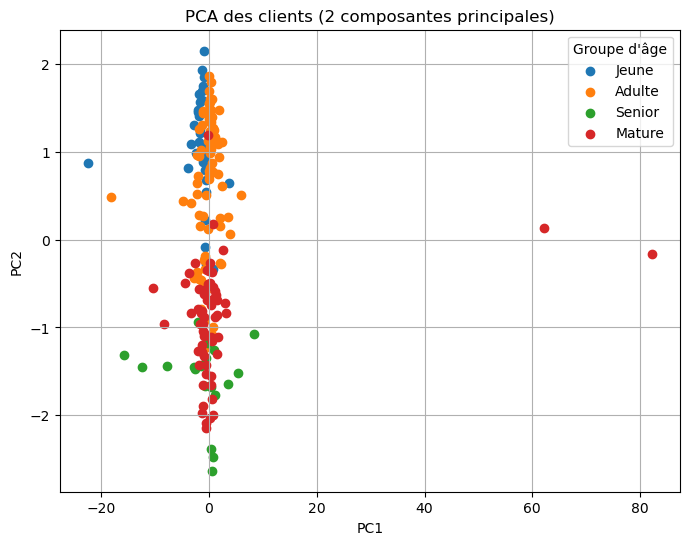

Variance expliquée par PC1: 95.49%, PC2: 2.00%


In [20]:

from sklearn.decomposition import PCA

# Préparation des données sans la variable catégorielle
features = df_fe.select_dtypes(include=[float, int]).drop(columns=['Annual Income (k$)', 'Spending Score (1-100)'], errors='ignore')

# Application de la PCA
pca = PCA(n_components=2)
components = pca.fit_transform(df_fe[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_Score_Ratio']])

# Création d'un DataFrame pour les composantes
pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
pca_df['AgeGroup'] = df_fe['AgeGroup'].values

# Visualisation 2D
plt.figure(figsize=(8,6))
for group in pca_df['AgeGroup'].unique():
    subset = pca_df[pca_df['AgeGroup'] == group]
    plt.scatter(subset['PC1'], subset['PC2'], label=group)
plt.title('PCA des clients (2 composantes principales)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Groupe d'âge")
plt.grid(True)
plt.show()

# Variance expliquée
explained = pca.explained_variance_ratio_
print(f"Variance expliquée par PC1: {explained[0]:.2%}, PC2: {explained[1]:.2%}")

### Interprétations
- **Scatter PCA** : Permet d'observer la répartition des clients selon les deux composantes principales et d'identifier d'éventuels regroupements.
- **Variance expliquée** : Indique la part d'information conservée dans la projection 2D.


## 6. Clustering
- **Algorithme** : K-means avec k de 2 à 6.
- **Évaluation** : Méthodes elbow (inertie) et silhouette.

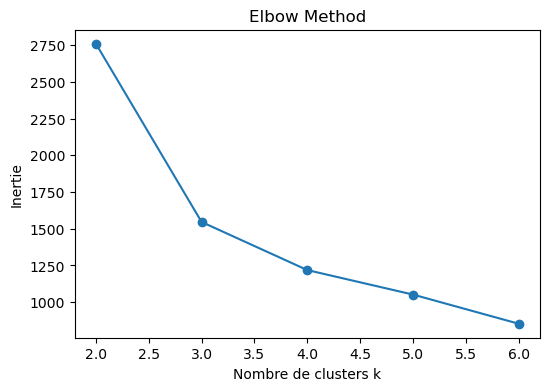

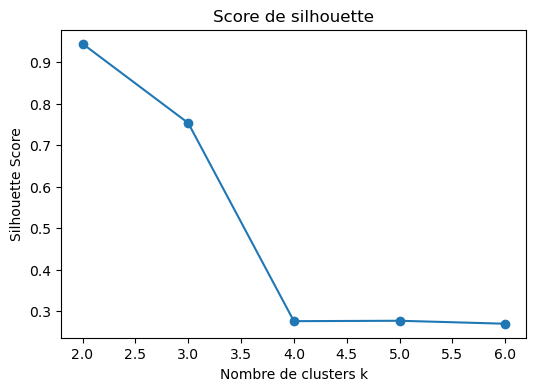

In [24]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Préparation des données pour le clustering
X = df_fe[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_Score_Ratio']]

# Calcul des inerties et silhouettes
inertias = []
silhouettes = []
ks = range(2, 7)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))

# Plot elbow
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Inertie')
plt.show()

# Plot silhouette scores
plt.figure(figsize=(6,4))
plt.plot(ks, silhouettes, marker='o')
plt.title('Score de silhouette')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Silhouette Score')
plt.show()


## 7. Interprétation des clusters
- **Analyse des centroïdes** et **visualisation en 2D** (PCA) colorée par cluster.

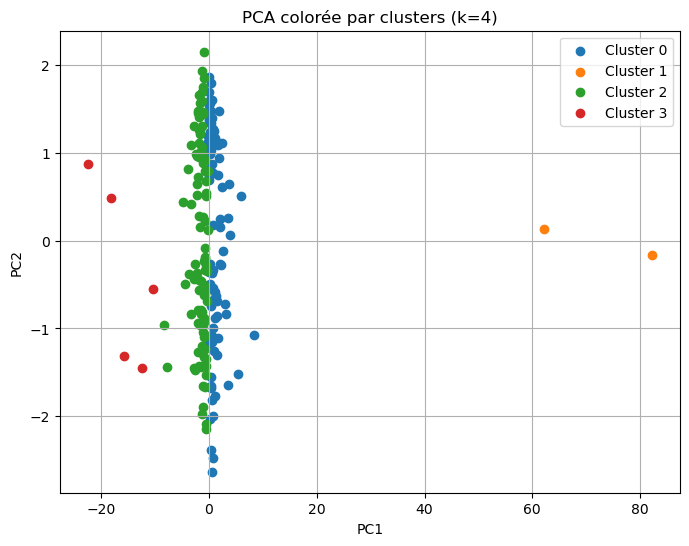

,Age,Annual Income (k$),Spending Score (1-100),Income_Score_Ratio
0,0.098913,0.017209,0.222211,1.423261
1,0.584899,-0.555747,-0.007764,72.510994
2,-0.122821,0.009992,-0.203410,-1.286854
3,0.427012,-0.296195,0.023293,-15.522084


In [27]:

# Choix du k optimal (ex. k=4 d'après silhouette)
optimal_k = 4
kmeans_opt = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_opt.fit_predict(X)

# Ajout des labels au DataFrame PCA
pca_df['Cluster'] = cluster_labels

# Visualisation 2D par cluster
plt.figure(figsize=(8,6))
for cluster in range(optimal_k):
    subset = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}')
plt.title(f'PCA colorée par clusters (k={optimal_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

# Analyse des centroïdes
centroids = pd.DataFrame(kmeans_opt.cluster_centers_, columns=X.columns)
centroids


## 8. Conclusions
  **Pertinence** : 
- Les groupes identifiés semblent cohérents en fonction des profils « Âge », « Revenu », « Score de dépense » et du ratio « Revenu/Score », avec une variance expliquée satisfaisante en PCA 2D. 
- Les centroïdes montrent clairement des segments « jeunes à fort potentiel d’achat », « seniors à faible dépense », etc., ce qui peut guider les actions marketing ciblées.
  **Suggestions d’améliorations** :
- Affiner k, tester d'autres algorithmes (DBSCAN, agglomératif), incorporer d'autres features.Clustering agglomératif hiérarchique (Ward, complete linkage) pour obtenir un dendrogramme et choisir k visuellement.

  **Enrichir le jeu de données** :
- Ajouter des variables qualitatives (genre, région, canal d’achat).
- Incorporer des historiques temporels (évolution du score de dépense mois par mois).